In [1]:
import tensorflow.keras as keras
import numpy as np
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import uproot
import utils
import tensorflow
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, GlobalAveragePooling1D
import tensorflow.keras.backend as K
from tqdm.notebook import tqdm

In [2]:
import XRootD

In [3]:
import yaml

with open('definitions.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions = yaml.load(file, Loader=yaml.FullLoader)
    
features = definitions['features']
spectators = definitions['spectators']
labels = definitions['labels']

nfeatures = definitions['nfeatures']
nspectators = definitions['nspectators']
nlabels = definitions['nlabels']
ntracks = definitions['ntracks']

# Jet Images

In [4]:
import yaml

with open('definitions_image.yml') as file:
    # The FullLoader parameter handles the conversion from YAML
    # scalar values to Python the dictionary format
    definitions_image = yaml.load(file, Loader=yaml.FullLoader)
    
features_image = definitions_image['features']
spectators_image = definitions_image['spectators']
labels_image = definitions_image['labels']

nfeatures_image = definitions_image['nfeatures']
nspectators_image = definitions_image['nspectators']
nlabels_image = definitions_image['nlabels']

In [5]:
feature_array, y, spec_array = utils.get_features_labels('~/teams/DSC180A_FA21_A00/a11/train/ntuple_merged_10.root', 
                                                         features_image, spectators_image, labels_image,
                                                         remove_mass_pt_window=False,
                                                         entry_stop=10000)
# make image
X = utils.make_image(feature_array)
print(X.shape) # image is a 4D tensor (n_samples, n_pixels_x, n_pixels_y, n_channels)

(9375, 224, 224, 1)


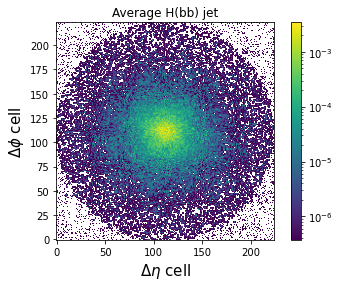

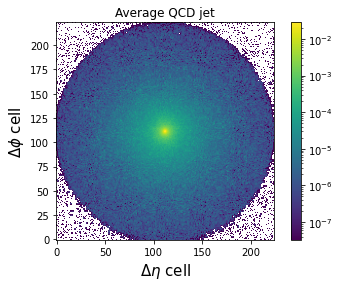

In [6]:
from matplotlib.colors import LogNorm

plt.figure()
plt.title('Average H(bb) jet')
plt.imshow(np.mean(X[y[:,1]==1],axis=0), origin='lower', norm=LogNorm())
plt.colorbar()
plt.xlabel(r"$\Delta\eta$ cell", fontsize=15)
plt.ylabel(r"$\Delta\phi$ cell", fontsize=15)
plt.show()

plt.figure()
plt.title('Average QCD jet')
plt.imshow(np.mean(X[y[:,0]==1],axis=0), origin='lower', norm=LogNorm())
plt.colorbar()
plt.xlabel(r"$\Delta\eta$ cell", fontsize=15)
plt.ylabel(r"$\Delta\phi$ cell", fontsize=15)
plt.show()

# Fully Connected Neural Network Classifier

In [7]:
from DataGenerator import DataGenerator

In [8]:
# load training and test generators 
train_files = ['~/teams/DSC180A_FA21_A00/a11/train/ntuple_merged_10.root']
test_files = ['~/teams/DSC180A_FA21_A00/a11/test/ntuple_merged_0.root']


train_generator = DataGenerator(train_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=True, max_entry=8000)

test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=True, max_entry=2000)

In [9]:
#validation
vtrain_files = ['~/teams/DSC180A_FA21_A00/a11/train/ntuple_merged_11.root']
vtest_files = ['~/teams/DSC180A_FA21_A00/a11/test/ntuple_merged_1.root']


vtrain_generator = DataGenerator(vtrain_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=True, max_entry=8000)

vtest_generator = DataGenerator(vtest_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=True, max_entry=2000)

In [10]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Flatten
import tensorflow.keras.backend as K

# define dense keras model
inputs = Input(shape=(ntracks, nfeatures,), name='input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Flatten(name='flatten_1')(x)
x = Dense(64, name='dense_1', activation='relu')(x)
x = Dense(32, name='dense_2', activation='relu')(x)
x = Dense(32, name='dense_3', activation='relu')(x)
outputs = Dense(nlabels, name='output', activation='softmax')(x)
keras_model_dense = Model(inputs=inputs, outputs=outputs)
keras_model_dense.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model_dense.summary())

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 60, 48)]          0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 60, 48)            192       
_________________________________________________________________
flatten_1 (Flatten)          (None, 2880)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                184384    
_________________________________________________________________
dense_2 (Dense)              (None, 32)                2080      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
output (Dense)               (None, 2)                 66    

2021-12-07 04:15:53.982396: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/pkgs/cudatoolkit-11.2.2-he111cf0_8/lib/:
2021-12-07 04:15:53.982441: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2021-12-07 04:15:53.982481: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:163] no NVIDIA GPU device is present: /dev/nvidia0 does not exist
2021-12-07 04:15:53.982898: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [11]:
# define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5)
model_checkpoint = ModelCheckpoint('keras_model_dense_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# fit keras model
history_dense = keras_model_dense.fit(train_generator,
                                      validation_data=vtrain_generator,
                                      steps_per_epoch=len(train_generator),
                                      validation_steps=len(vtrain_generator),
                                      max_queue_size=5,
                                      epochs=20,
                                      shuffle=False,
                                      callbacks=callbacks,
                                      verbose=0)
# reload best weights
keras_model_dense.load_weights('keras_model_dense_best.h5')

2021-12-07 04:15:54.958932: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


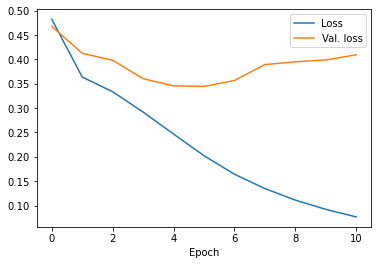

In [12]:
plt.figure()
plt.plot(history_dense.history['loss'], label='Loss')
plt.plot(history_dense.history['val_loss'], label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

# Deep Sets Neural Network

In [13]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, GlobalAveragePooling1D
import tensorflow.keras.backend as K

# define Deep Sets model with Dense Keras layer
inputs = Input(shape=(ntracks, nfeatures,), name='input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Dense(64, name='dense_1', activation='relu')(x)
x = Dense(32, name='dense_2', activation='relu')(x)
x = Dense(32, name='dense_3', activation='relu')(x)
# sum over tracks
x = GlobalAveragePooling1D(name='pool_1')(x)
x = Dense(100, name='dense_4', activation='relu')(x)
outputs = Dense(nlabels, name='output', activation='softmax')(x)
keras_model_deepset = Model(inputs=inputs, outputs=outputs)
keras_model_deepset.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
print(keras_model_deepset.summary())

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 60, 48)]          0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 60, 48)            192       
_________________________________________________________________
dense_1 (Dense)              (None, 60, 64)            3136      
_________________________________________________________________
dense_2 (Dense)              (None, 60, 32)            2080      
_________________________________________________________________
dense_3 (Dense)              (None, 60, 32)            1056      
_________________________________________________________________
pool_1 (GlobalAveragePooling (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               3300

In [14]:
# define callbacks
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

early_stopping = EarlyStopping(monitor='val_loss', patience=5)
reduce_lr = ReduceLROnPlateau(patience=5, factor=0.5)
model_checkpoint = ModelCheckpoint('keras_model_deepset_best.h5', monitor='val_loss', save_best_only=True)
callbacks = [early_stopping, model_checkpoint, reduce_lr]

# fit keras model
history_deepset = keras_model_deepset.fit(train_generator, 
                                          validation_data=vtrain_generator, 
                                          steps_per_epoch=len(train_generator), 
                                          validation_steps=len(vtrain_generator),
                                          max_queue_size=5,
                                          epochs=20, 
                                          shuffle=False,
                                          callbacks=callbacks, 
                                          verbose=0)
# reload best weights
keras_model_deepset.load_weights('keras_model_deepset_best.h5')

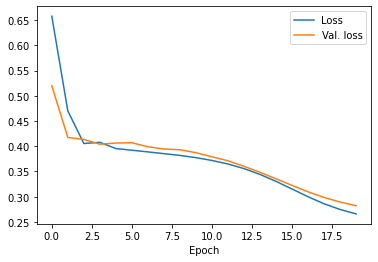

In [15]:
plt.figure()
plt.plot(history_deepset.history['loss'], label='Loss')
plt.plot(history_deepset.history['val_loss'], label='Val. loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [16]:
test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                               remove_mass_pt_window=True, 
                               remove_unlabeled=True)

In [17]:
from utils import find_nearest

def find_nearest(array,value):
    idx = (np.abs(array-value)).argmin()
    return idx, array[idx]

## Evaluating Performance w/ DDT
### (Designing Decorrelated Taggers)

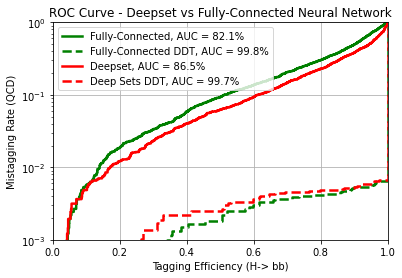

In [18]:
# run model inference on test data set
predict_array_dense = []
predict_array_deepset = []
label_array_test = []

for t in test_generator:
    label_array_test.append(t[1])
    predict_array_dense.append(keras_model_dense.predict(t[0]))
    predict_array_deepset.append(keras_model_deepset.predict(t[0]))
    
    
predict_array_dense = np.concatenate(predict_array_dense, axis=0)
predict_array_deepset = np.concatenate(predict_array_deepset, axis=0)
label_array_test = np.concatenate(label_array_test, axis=0)


# create ROC curves
fpr_dense, tpr_dense, threshold_dense = roc_curve(label_array_test[:,1], predict_array_dense[:,1])
fpr_deepset, tpr_deepset, threshold_deepset = roc_curve(label_array_test[:,1], predict_array_deepset[:,1])

##DDT procedure
cutoff = 0.01
idx_dense, val_dense = find_nearest(fpr_dense, cutoff)
idx_deepset, val_deepset = find_nearest(fpr_deepset, cutoff)

label_array_test_dense_ddt = label_array_test[:, 1] * (predict_array_dense[:, 1] > threshold_dense[idx_dense])
label_array_test_deepset_ddt = label_array_test[:, 1] * (predict_array_deepset[:, 1] > threshold_deepset[idx_deepset])
#ddt curves
fpr_dense_ddt, tpr_dense_ddt, threshold_dense_ddt = roc_curve(label_array_test_dense_ddt, predict_array_dense[:,1])
fpr_deepset_ddt, tpr_deepset_ddt, threshold_deepset_ddt = roc_curve(label_array_test_deepset_ddt, predict_array_deepset[:,1])

    
# plot curves
plt.figure()
# ROC curves
plt.plot(tpr_dense, fpr_dense, color = 'green', lw=2.5, label="Fully-Connected, AUC = {:.1f}%".format(auc(fpr_dense, tpr_dense)*100))
plt.plot(tpr_dense_ddt, fpr_dense_ddt, color = 'green', linestyle = '--', lw=2.5, label="Fully-Connected DDT, AUC = {:.1f}%".format(auc(fpr_dense_ddt, tpr_dense_ddt)*100))
plt.plot(tpr_deepset, fpr_deepset, color = 'red', lw=2.5, label="Deepset, AUC = {:.1f}%".format(auc(fpr_deepset, tpr_deepset)*100))
plt.plot(tpr_deepset_ddt, fpr_deepset_ddt, color = 'red', linestyle = '--', lw=2.5, label="Deep Sets DDT, AUC = {:.1f}%".format(auc(fpr_deepset_ddt, tpr_deepset_ddt)*100))

plt.xlabel(r'Tagging Efficiency (H-> bb)')
plt.ylabel(r'Mistagging Rate (QCD)')
plt.title('ROC Curve - Deepset vs Fully-Connected Neural Network')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

# Deep Sets Adversarial Discrimnation/Regression Neural Network

### Trained discrimination using combined loss function
$$L = L_\mathrm{class} - \lambda L_\mathrm{reg}$$
### Trained regression to identify using mass using standard MSE loss function 
$$L_\mathrm{reg}$$


In [19]:
# load training and test generators 
train_files = ['~/teams/DSC180A_FA21_A00/a11/train/ntuple_merged_10.root']
test_files = ['~/teams/DSC180A_FA21_A00/a11/test/ntuple_merged_0.root']


train_generator = DataGenerator(train_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, remove_unlabeled=True,
                                max_entry=5000, return_spectators=True, scale_mass_pt=[100., 10000.])

test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=1024, n_dim=ntracks, 
                                remove_mass_pt_window=False, 
                                remove_unlabeled=True, max_entry=5000,
                                return_spectators=True, scale_mass_pt=[100., 10000.])

In [20]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, BatchNormalization, Concatenate, GlobalAveragePooling1D
import tensorflow.keras.backend as K

# define Deep Sets model with Dense Keras layer
inputs = Input(shape=(ntracks, nfeatures,), name='input')  
x = BatchNormalization(name='bn_1')(inputs)
x = Dense(64, name='dense_1', activation='relu')(x)
x = Dense(32, name='dense_2', activation='relu')(x)
x = Dense(32, name='dense_3', activation='relu')(x)
# sum over tracks
x = GlobalAveragePooling1D(name='pool_1')(x)
x = Dense(100, name='dense_4', activation='relu')(x)
output = Dense(nlabels, name = 'output', activation='softmax')(x)
    
keras_model_disc = Model(inputs=inputs, outputs=output)
keras_model_disc.compile(optimizer='adam',
                        loss='categorical_crossentropy')

# regressor
x = Dense(100, name='dense_5', activation='relu')(keras_model_disc(inputs))
x = Dense(100, name='dense_6', activation='relu')(x)
output_reg = Dense(2, activation='linear', name='mass_pt_reg')(x)
                                                            

sgd_opt = keras.optimizers.SGD(momentum=0)
keras_model_reg = Model(inputs=inputs, outputs=output_reg)
keras_model_reg.compile(optimizer=sgd_opt,
                        loss='mse')

# combined model
lam = 10
keras_model_adv = Model(inputs=inputs, outputs=[keras_model_disc(inputs), keras_model_reg(inputs)])
keras_model_adv.compile(optimizer=sgd_opt, 
                        loss=['categorical_crossentropy', 'mse'],
                        loss_weights = [1, -lam])                              

print(keras_model_disc.summary())
print(keras_model_reg.summary())
print(keras_model_adv.summary())

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           [(None, 60, 48)]          0         
_________________________________________________________________
bn_1 (BatchNormalization)    (None, 60, 48)            192       
_________________________________________________________________
dense_1 (Dense)              (None, 60, 64)            3136      
_________________________________________________________________
dense_2 (Dense)              (None, 60, 32)            2080      
_________________________________________________________________
dense_3 (Dense)              (None, 60, 32)            1056      
_________________________________________________________________
pool_1 (GlobalAveragePooling (None, 32)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 100)               3300

# Training

In [21]:
# pretrain discriminator
keras_model_disc.trainable = True
keras_model_disc.compile(optimizer='adam',
                         loss='categorical_crossentropy')
for n_epoch in tqdm(range(20)):
    for t in tqdm(train_generator, total=len(train_generator), leave=bool(n_epoch==19)):
        keras_model_disc.fit(t[0], t[1][0],verbose=0)        
        
# pretrain regressor
keras_model_reg.trainable = True
keras_model_disc.trainable = False
keras_model_reg.compile(optimizer=sgd_opt, loss='mse')
for n_epoch in tqdm(range(20)):
    for t in tqdm(train_generator, total=len(train_generator), leave=bool(n_epoch==19)):
        keras_model_reg.fit(t[0], t[1][1], verbose=0) 

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

In [22]:
# alternate training discriminator and regressor                    
for n_epoch in tqdm(range(40)):
    for t in tqdm(train_generator, total=len(train_generator), leave=bool(n_epoch==39)):
        # train discriminator
        keras_model_reg.trainable = False
        keras_model_disc.trainable = True
        keras_model_adv.compile(optimizer=sgd_opt, 
                        loss=['categorical_crossentropy', 'mse'],
                        loss_weights=[1, -lam])    
        keras_model_adv.fit(t[0], t[1], verbose=0)

        # train regressor
        keras_model_reg.trainable = True
        keras_model_disc.trainable = False
        keras_model_reg.compile(optimizer=sgd_opt, loss='mse')
        keras_model_reg.fit(t[0], t[1][1],verbose=0)
keras_model_adv.save_weights('keras_model_adv_best.h5')

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

# Model Performance

## Evaluating Model Performance w/ DDT 

In [23]:
# load testing file
test_files = ['~/teams/DSC180A_FA21_A00/a11/test/ntuple_merged_0.root']
test_generator = DataGenerator(test_files, features, labels, spectators, batch_size=8192, n_dim=ntracks, 
                               remove_mass_pt_window=True, 
                               remove_unlabeled=True,
                               return_spectators=True,
                               max_entry=200000) # basically, no maximum

In [24]:
# run model inference on test data set
predict_array_adv = []
label_array_test = []
spec_array_test = []

for t in tqdm(test_generator, total=len(test_generator)):
    label_array_test.append(t[1][0])
    spec_array_test.append(t[1][1])
    predict_array_adv.append(keras_model_adv.predict(t[0])[0])
predict_array_adv = np.concatenate(predict_array_adv, axis=0)
label_array_test = np.concatenate(label_array_test, axis=0)
spec_array_test = np.concatenate(spec_array_test, axis=0)

  0%|          | 0/25 [00:00<?, ?it/s]

(63049, 2)
(63049, 2)
(63049, 2)


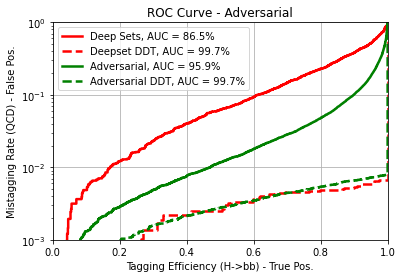

In [25]:
# create ROC curves
print(label_array_test.shape)
print(spec_array_test.shape)
print(predict_array_adv.shape)


#ROC Curve
fpr_adv, tpr_adv, threshold_adv = roc_curve(label_array_test[:,1], predict_array_adv[:,1])
#DDT Procedure
cutoff = 0.01
idx_adv, val_adv = find_nearest(fpr_adv, cutoff)
label_array_test_adv_ddt = label_array_test[:, 1] * (predict_array_adv[:,1] > threshold_adv[idx_adv])

fpr_adv_ddt, tpr_adv_ddt, threshold_adv_ddt = roc_curve(label_array_test_adv_ddt, predict_array_adv[:,1])


# plot ROC curves
plt.figure()
plt.plot(tpr_deepset, fpr_deepset, color = 'red', lw=2.5, label="Deep Sets, AUC = {:.1f}%".format(auc(fpr_deepset, tpr_deepset)*100))
plt.plot(tpr_deepset_ddt, fpr_deepset_ddt, color = 'red', linestyle='--', lw=2.5, label="Deepset DDT, AUC = {:.1f}%".format(auc(fpr_deepset_ddt, tpr_deepset_ddt)*100))
plt.plot(tpr_adv, fpr_adv, lw=2.5, color = 'green', label="Adversarial, AUC = {:.1f}%".format(auc(fpr_adv,tpr_adv)*100))
plt.plot(tpr_adv_ddt, fpr_adv_ddt, color = 'green', linestyle='--', lw=2.5, label="Adversarial DDT, AUC = {:.1f}%".format(auc(fpr_adv_ddt, tpr_adv_ddt)*100))

plt.xlabel(r'Tagging Efficiency (H->bb) - True Pos.')
plt.ylabel(r'Mistagging Rate (QCD) - False Pos.')
plt.title('ROC Curve - Adversarial')
plt.semilogy()
plt.ylim(0.001, 1)
plt.xlim(0, 1)
plt.grid(True)
plt.legend(loc='upper left')
plt.show()

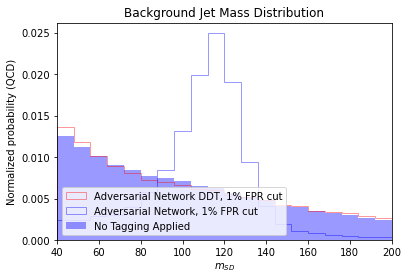

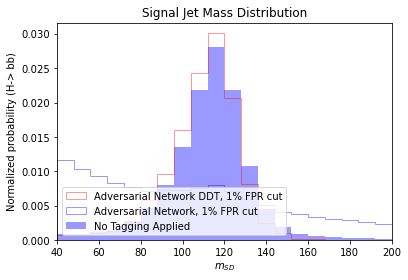

In [26]:
plt.figure()
for wp in [0.01]:
    idx, val = find_nearest(fpr_adv, wp)
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights= label_array_test[:, 0] * (predict_array_adv[:,0] > threshold_adv[idx_adv]),
             alpha=0.4, density=True, color = 'red',label='Adversarial Network DDT, {}% FPR cut'.format(int(wp*100)),histtype='step')
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=predict_array_adv[:,1],
             alpha=0.4, density=True, color = 'blue',label='Adversarial Network, {}% FPR cut'.format(int(wp*100)), histtype='step')
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=label_array_test[:,0],
             alpha=0.4, density=True, color = 'blue', label='No Tagging Applied'.format(int(wp*100)))
    plt.title("Background Jet Mass Distribution")
plt.legend(loc='lower left')
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability (QCD)')
plt.xlim(40, 200)

plt.figure()
for wp in [0.01]:
    idx, val = find_nearest(fpr_adv, wp)
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=label_array_test_adv_ddt,
             alpha=0.4, density=True, color='red', label='Adversarial Network DDT, {}% FPR cut'.format(int(wp*100)),histtype='step')
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=predict_array_adv[:,0],
             alpha=0.4, density=True, color = 'blue',label='Adversarial Network, {}% FPR cut'.format(int(wp*100)), histtype='step')
    plt.hist(spec_array_test[:,0], bins=np.linspace(40, 200, 21), 
             weights=label_array_test[:,1],
             alpha=0.4, density=True, color = 'blue', label='No Tagging Applied'.format(int(wp*100)))
    plt.title("Signal Jet Mass Distribution")
plt.legend(loc='lower left')
plt.xlabel(r'$m_{SD}$')
plt.ylabel(r'Normalized probability (H-> bb)')
plt.xlim(40, 200)
plt.show()